In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Exercise 1: 

## Question 2:

In [37]:
def F(x, X, p):
    """ Cumulative Distribution Function F
    Parameters:
        X (list): list
        x (float): value
        p (list): probas
    Returns:
        k (int): as defined in the algorithm
    """
    n = len(X)
    proba = 0.0
    for k in range(n):
        if X[k] <= x:
            proba += p[k]
        else:
            break
    return proba


def algorithm1(X, p, cdf, n_sample):
    """ Algorithm 1 
    Parameters:
        X (list): list 
        p (list): probas
        n_sample (int): number of samples
    Returns:
        k (list): as defned in the algorithm
    """
    U = np.random.uniform(0, 1, n_sample)
    list_k = []
    for u in U:
        cumulative_sum = 0
        for idx, prob in enumerate(p):
            cumulative_sum += prob
            if cumulative_sum >= u:
                list_k.append(X[idx])
                break
    return list_k

n = 10 ** 4    # Dimension of the space
prob_vector = np.random.rand(n) / n
X = np.random.randint(0, 10 ** 5,
                      size = n)
X = np.sort(X)
X_simul = algorithm1(X, prob_vector, F, 100)
print("Random simulations from X:", np.random.choice(X_simul, 10, replace=False))

Random simulations from X: [18303 11052 78771 66414 39136 60078 97314 50741 45610  2439]


## Question 3:

We test our implementation on $(X_i)_{i \in \left[ 1,n \right]}$ from a $\mathcal{G} (p) $ distribution. 

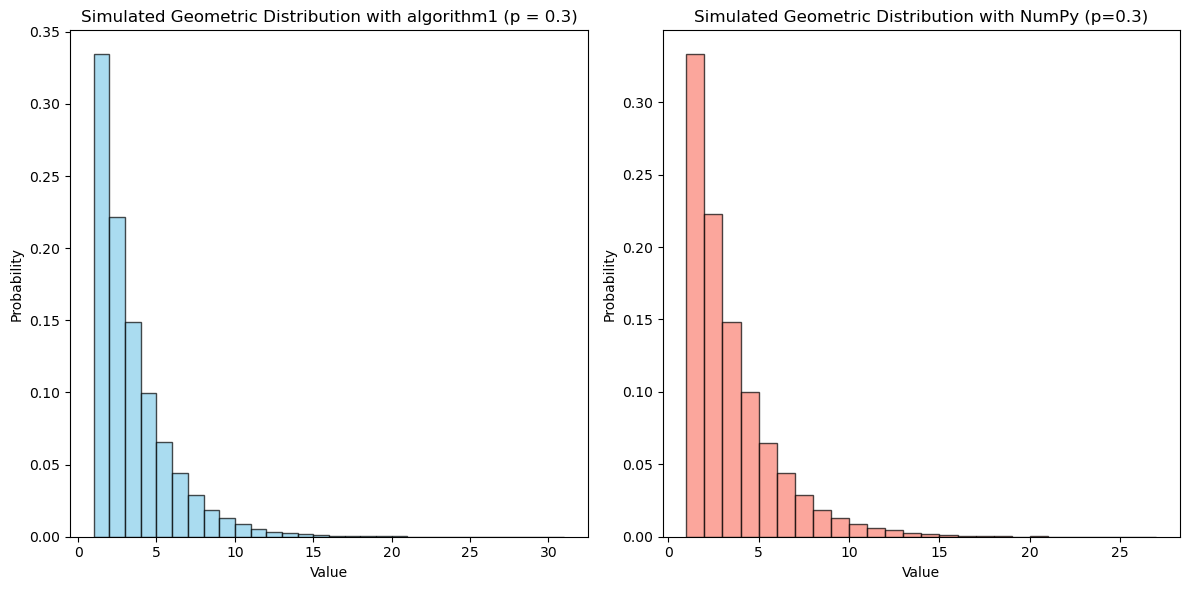

In [41]:
import scipy.stats as stats

p = 1 / 3
X = np.arange(1, 1000)
n_samples = 500_000
prob_vector = (1 - p) ** (X - 1) * p
prob_vector /= prob_vector.sum()

n_samples = 10 ** 5
samples_custom = algorithm1(X, prob_vector, F, n_samples)
samples_numpy = np.random.geometric(p, n_samples)

# Plot the histogram of both samples for comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(samples_custom, bins = range(1, max(samples_custom) + 1), density = True, alpha=0.7, color = 'skyblue', edgecolor = 'black')
plt.title("Simulated Geometric Distribution with algorithm1 (p = 0.3)")
plt.xlabel("Value")
plt.ylabel("Probability")

plt.subplot(1, 2, 2)
plt.hist(samples_numpy, bins = range(1, max(samples_numpy) + 1), density = True, alpha = 0.7, color='salmon', edgecolor = 'black')
plt.title("Simulated Geometric Distribution with NumPy (p=0.3)")
plt.xlabel("Value")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()